In [1]:
import sys
import numpy as np
import torch 
# still do preprocessing in scipy
import scipy.sparse as sp
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from importlib import reload
import pandas as pd 
import seaborn as sns

# import nn PCA model from nuclear-norm-pca
sys.path.append('/gpfs/commons/home/kisaev/Leaflet/src/nuclear-norm-pca')
import kuckle_model
from kuckle_model import *

### Settings and Load data

In [2]:
leaflet_repo = '/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/' #need to move load_cluster_data function to general module utils 
sys.path.append(leaflet_repo)
import load_cluster_data
from betabinomo_mix_singlecells import *

In [3]:
torch.manual_seed(42)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

cpu


In [4]:
input_files_folder = '/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/'
cell_types = ['Brain_Non-Myeloid_brain_pericyte',
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell',
 'Brain_Non-Myeloid_endothelial_cell' 'Brain_Non-Myeloid_oligodendrocyte',
 'Brain_Non-Myeloid_neuron', 'Brain_Myeloid_macrophage',
 'Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte']#ignoring Bergmann_glial_cell since very few cells

# convert data to Leaflet required input formats 
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data.load_cluster_data(
    input_folder = input_files_folder, max_intron_count=5000, celltypes=cell_types, has_genes="yes") 

# add cluster to final_data 
final_data = final_data.merge(junction_ids_conversion, on=["junction_id_index"], how="left")

# get indices (maybe don't need this actually)
indices = (final_data.cell_id_index, final_data.junction_id_index)
indices_np = np.stack(indices)
junc_counts = sp.coo_matrix((final_data.junc_count, indices))
cluster_counts = sp.coo_matrix((final_data.cluster_count, indices))

Reading in data from folder ...
/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/
Finished reading in data from folder ...
Looking at only specific cell types ...['Brain_Non-Myeloid_brain_pericyte', 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell', 'Brain_Non-Myeloid_endothelial_cellBrain_Non-Myeloid_oligodendrocyte', 'Brain_Non-Myeloid_neuron', 'Brain_Myeloid_macrophage', 'Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte']
['Brain_Non-Myeloid_brain_pericyte'
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell'
 'Brain_Non-Myeloid_neuron' 'Brain_Myeloid_macrophage'
 'Brain_Myeloid_microglial_cell' 'Brain_Non-Myeloid_astrocyte']
5527
13952
The maximum junction count was initially:  36797
33
The maximum junction count is now:  4982
                                             cell_id  Cluster  Cluster_Counts  \
0  A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...        4              21   
1  A14-MAA000581-3_10_M-1-1_Brain_Non

### Filter junctions and set up Y and W (weight matrix of inverse variances of the PSI values)

also printing original indices of junctions we are keeping


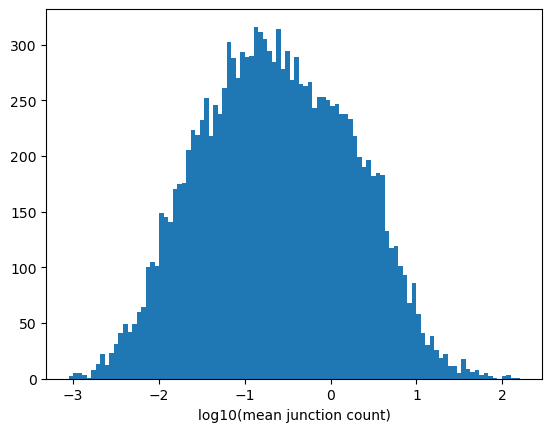

In [5]:
junc_counts_sub, cluster_counts_sub, junc_keep = filter_junctions(
    junc_counts, cluster_counts, plot = True)

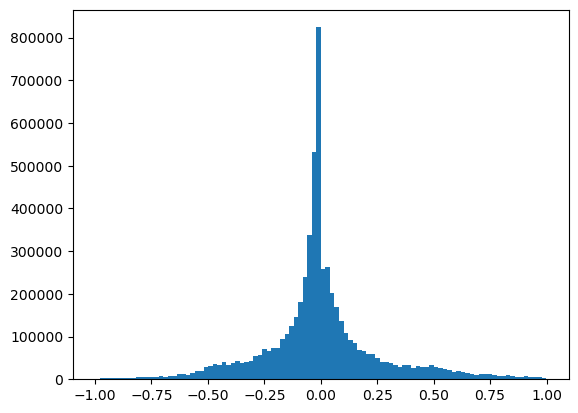

In [6]:
# set up data for nuc norm PCA
Y_data, w = make_Y(
    junc_counts_sub, cluster_counts_sub, float_type)

# np.mean(Y_data * Y_data) * psi.shape[0] * psi.shape[1]
Y = torch.tensor(Y_data, **float_type)
W = torch.tensor(w.data, **float_type)

_ = plt.hist(Y_data, 100) # centered so the distribution peaks at 0 and is in [-1,1]

### Split into training and test data 

In [7]:
Y_train, W_train, indices_train, Y_test, W_test, indices_test = train_test(
    Y_data, w, float_type)

### Run nuclear norm PCA constraint search 

In [8]:
rmseTol = 5e-5
its=10

rs, testErrors, trainErrors, nuc_norms, final_svd, step_times = constraint_search(
    indices_train, 
    Y_train, 
    W_train, 
    size = junc_counts_sub.shape,
    indices_test = indices_test, 
    Y_test = Y_test, 
    W_test = W_test, 
    rmseTol = rmseTol, 
    end = "\n",
    inner_verbose = True,
    power_iteration_controller = (30,1.),
    its = its,  
    **float_type)

CV	Bound	RMSE	TestRMSE
It	RMSE	Step	DeltaRMSE


/gpfs/commons/home/kisaev/Leaflet/src/nuclear-norm-pca/kuckle_model.py:311: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(phi, dtype = float_type["dtype"], device = "cpu") # this is always on CPU


CV	1e+03	0.224	0.228
It	RMSE	Step	DeltaRMSE
CV	1.5e+03	0.219	0.2274295
It	RMSE	Step	DeltaRMSE
CV	2.25e+03	0.214	0.225532
It	RMSE	Step	DeltaRMSE
CV	3.38e+03	0.21	0.2243971
It	RMSE	Step	DeltaRMSE
CV	5.06e+03	0.205	0.2236912
It	RMSE	Step	DeltaRMSE
CV	7.59e+03	0.202	0.2233442
It	RMSE	Step	DeltaRMSE
CV	1.14e+04	0.198	0.2233362
It	RMSE	Step	DeltaRMSE
CV	1.71e+04	0.194	0.2225517
It	RMSE	Step	DeltaRMSE
CV	2.56e+04	0.191	0.2226938
It	RMSE	Step	DeltaRMSE
CV	3.84e+04	0.187	0.22233574
It	RMSE	Step	DeltaRMSE
CV	5.77e+04	0.184	0.22232283
It	RMSE	Step	DeltaRMSE


### Plot results 

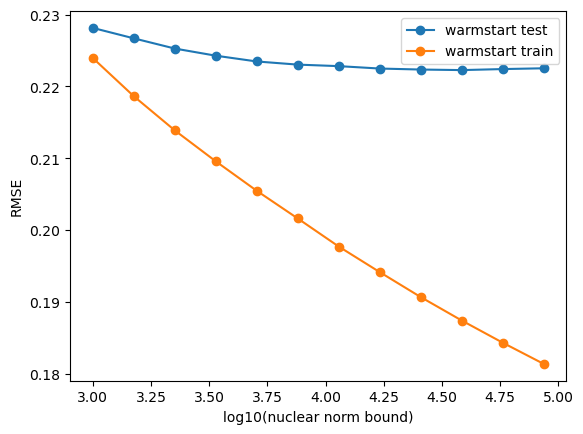

In [9]:
plt.plot(np.log10(rs), testErrors,"-o", label = "warmstart test") #rs = list of nuclear norm bounds used 
plt.plot(np.log10(rs), trainErrors, "-o", label = "warmstart train")
plt.ylabel("RMSE")
plt.xlabel("log10(nuclear norm bound)")
plt.legend()

tensor(3744.3047)

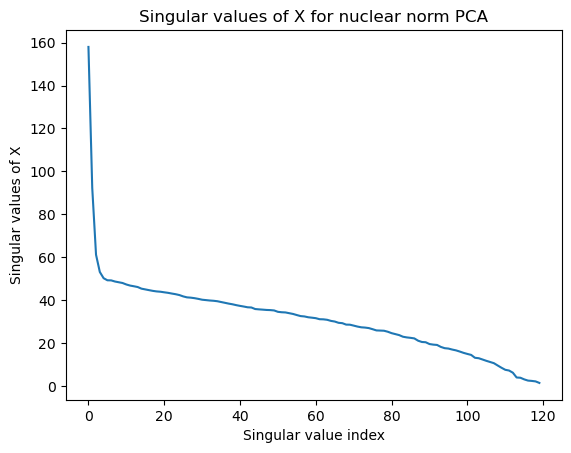

In [10]:
plt.plot(final_svd.S)
plt.ylabel("Singular values of X") 
plt.xlabel("Singular value index")
# add title
plt.title("Singular values of X for nuclear norm PCA")
final_svd.S.sum()

In [11]:
nuc_norms # nuc_norms.append(final_svd.S.sum().item())

[418.2597961425781,
 719.1729125976562,
 1014.4820556640625,
 1311.5333251953125,
 1617.489013671875,
 1926.705322265625,
 2261.70703125,
 2567.25,
 2877.478271484375,
 3174.0126953125,
 3464.936279296875,
 3744.3046875]

Text(0, 0.5, 'log10(Nuc norm obtained)')

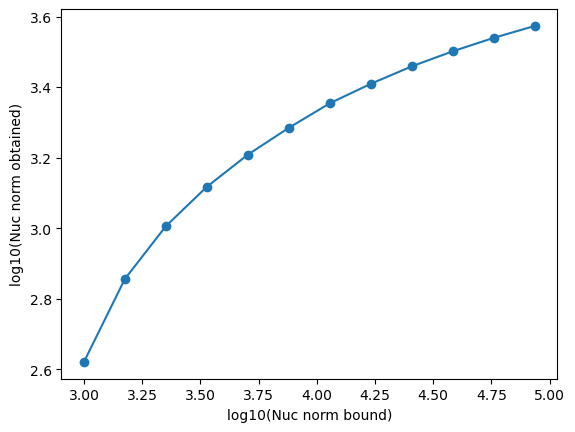

In [12]:
# solution is on the boundary up to about ~1e4, then is inside. 
plt.plot(np.log10(rs), np.log10(nuc_norms), "-o", label = "warmstart")
plt.xlabel("log10(Nuc norm bound)")
plt.ylabel("log10(Nuc norm obtained)")

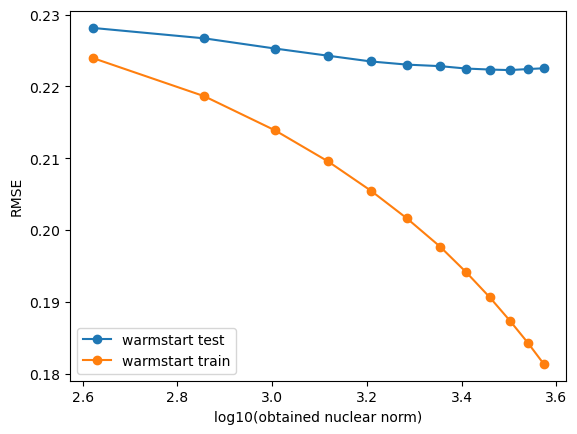

In [13]:
plt.plot(np.log10(nuc_norms), testErrors,"-o", label = "warmstart test")
plt.plot(np.log10(nuc_norms), trainErrors, "-o", label = "warmstart train")
plt.ylabel("RMSE")
plt.xlabel("log10(obtained nuclear norm)")
plt.legend()

In [14]:
r_best = rs[np.argmin(testErrors)]
r_best

38443.359375

In [15]:
Y,W,indices = to_torch(Y_data, w, **float_type)

### Re-run constraint_search with our best r_best

In [16]:
rs, _, trainErrors_all, nuc_norms_all, final_svd_all, step_times = constraint_search(
    indices, 
    Y, 
    W, 
    size = junc_counts_sub.shape,
    rmseTol = rmseTol, 
    its = its,  
    max_r = r_best, 
    end = "\n",
    **float_type)


CV	Bound	RMSE	TestRMSE
CV	1e+03	0.224	nan
CV	1.5e+03	0.22	nan
CV	2.25e+03	0.215	nan
CV	3.38e+03	0.212	nan
CV	5.06e+03	0.208	nan
CV	7.59e+03	0.205	nan
CV	1.14e+04	0.201	nan
CV	1.71e+04	0.198	nan
CV	2.56e+04	0.195	nan
CV	3.84e+04	0.192	nan


In [17]:
r_best

38443.359375

### Settings and Load data

Text(0.5, 1.0, 'Singular values of X for nuclear norm PCA')

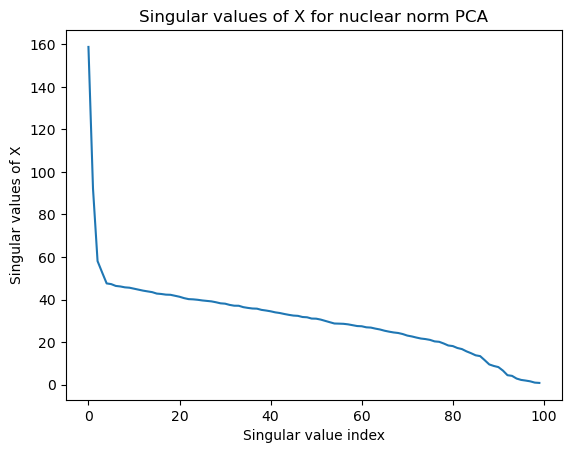

In [18]:
plt.plot(final_svd_all.S) # final_svd = orthonormer(U, V, phi) --> orthonormalization process on the singular vectors (stored in U and V) and singular values (phi) obtained from the nuc_norm_PCA
 # add xlab 
plt.xlabel("Singular value index")
# add ylab
plt.ylabel("Singular values of X")
# add title
plt.title("Singular values of X for nuclear norm PCA")

In [19]:
final_svd_all.U

tensor([[ 0.0078, -0.0076,  0.0475,  ...,  0.0066,  0.0055, -0.0019],
        [-0.0031, -0.0140,  0.0442,  ..., -0.0003,  0.0038, -0.0004],
        [ 0.0021, -0.0021,  0.0189,  ...,  0.0029,  0.0026, -0.0115],
        ...,
        [-0.0085, -0.0152, -0.0037,  ..., -0.0115, -0.0026,  0.0023],
        [-0.0127, -0.0203, -0.0002,  ...,  0.0227, -0.0002, -0.0067],
        [-0.0092, -0.0125,  0.0016,  ..., -0.0120,  0.0002, -0.0066]])

In [20]:
# convert to df and rename columns to be PCA_1, PCA_2, etc.
PC_df = pd.DataFrame(final_svd_all.U)
PC_df.columns = ["PCA_" + str(i) for i in range(1, PC_df.shape[1] + 1)]
PC_df["cell_type"] = cell_ids_conversion["cell_type"].to_numpy()
PC_df

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_92,PCA_93,PCA_94,PCA_95,PCA_96,PCA_97,PCA_98,PCA_99,PCA_100,cell_type
0,0.007764,-0.007553,0.047462,-0.010071,-0.001545,-0.021606,0.013560,-0.003564,0.000387,0.003897,...,0.001390,-0.011723,0.001021,-0.007071,0.000429,0.001318,0.006641,0.005539,-0.001941,Brain_Non-Myeloid_brain_pericyte
1,-0.003086,-0.014039,0.044163,0.025495,-0.013630,-0.002423,0.024345,-0.027232,-0.027053,0.013890,...,0.008416,-0.022272,0.016175,0.017688,-0.026176,-0.012167,-0.000280,0.003772,-0.000362,Brain_Non-Myeloid_brain_pericyte
2,0.002091,-0.002072,0.018865,0.004418,0.003361,-0.009844,-0.004849,-0.001484,0.010511,0.006348,...,-0.003476,-0.004538,-0.007950,-0.004707,-0.003748,0.004086,0.002912,0.002587,-0.011469,Brain_Non-Myeloid_brain_pericyte
3,0.000173,-0.022486,0.056911,0.005084,0.007286,0.003593,-0.005845,-0.010338,-0.000664,0.013636,...,0.010961,-0.003146,-0.001544,-0.004831,0.005720,0.011784,0.014900,0.001358,-0.017330,Brain_Non-Myeloid_brain_pericyte
4,-0.006051,-0.029488,0.079274,-0.030898,0.001408,-0.009653,0.005191,0.013851,0.010351,-0.032332,...,-0.017619,-0.082028,0.003521,-0.010196,-0.108979,-0.023023,0.003586,-0.024208,0.036166,Brain_Non-Myeloid_brain_pericyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5522,-0.003642,-0.007490,-0.000880,-0.009678,-0.009093,-0.006964,0.001216,-0.009878,-0.009047,0.001190,...,0.006096,-0.005316,0.016038,-0.010909,-0.009298,0.004525,-0.010269,-0.005627,-0.007038,Brain_Non-Myeloid_astrocyte
5523,-0.004176,-0.007726,-0.000831,-0.012315,0.000028,0.004266,-0.001000,0.003202,-0.001191,-0.000659,...,-0.001722,0.001852,-0.004296,-0.001054,-0.000685,0.007280,-0.007194,-0.002384,-0.002663,Brain_Non-Myeloid_astrocyte
5524,-0.008547,-0.015206,-0.003729,-0.009660,0.000834,0.017003,-0.001351,-0.003623,0.002446,0.012884,...,0.014401,0.012342,0.003257,-0.009113,-0.000432,0.004897,-0.011475,-0.002635,0.002285,Brain_Non-Myeloid_astrocyte
5525,-0.012677,-0.020281,-0.000159,-0.023971,0.005529,0.003762,-0.004325,0.006343,0.007666,-0.009805,...,-0.007085,-0.015518,0.042617,-0.001013,-0.008513,0.015075,0.022702,-0.000165,-0.006676,Brain_Non-Myeloid_astrocyte


<Axes: xlabel='PCA_1', ylabel='PCA_2'>

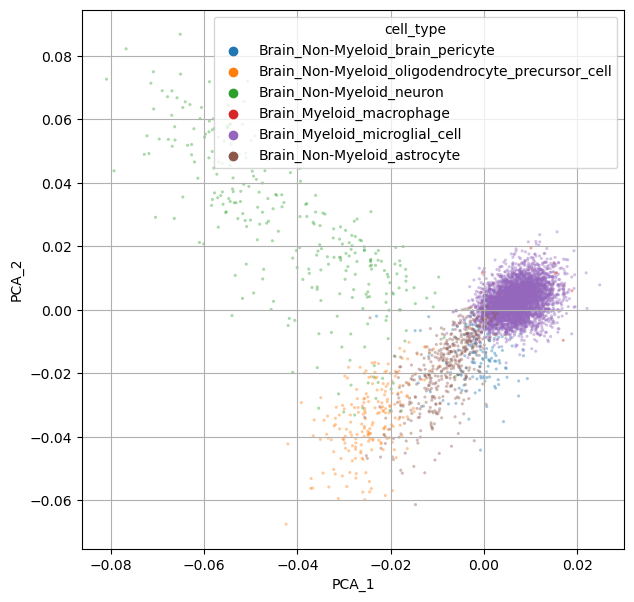

In [21]:
plt.figure(figsize=[7,7])
# add grid to plot
plt.grid()
sns.scatterplot(x = "PCA_1",y = "PCA_2", hue="cell_type", data= PC_df, edgecolor = 'none', alpha = 0.4, s=5)

<Axes: xlabel='PCA_1', ylabel='PCA_3'>

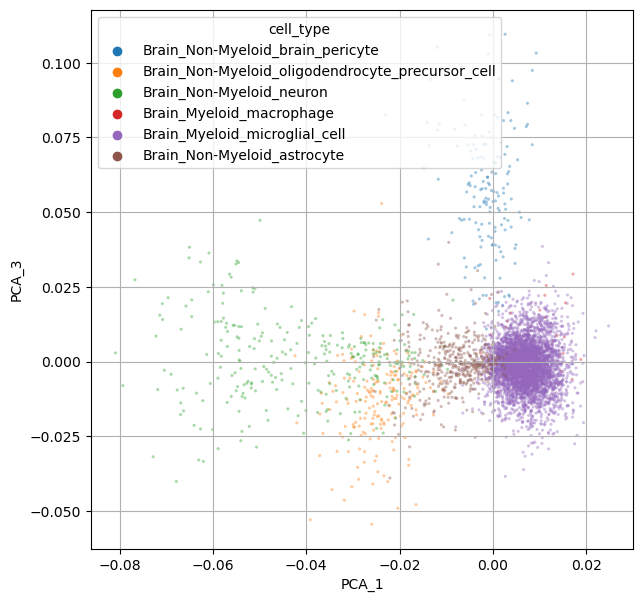

In [22]:
plt.figure(figsize=[7,7])
# add grid to plot
plt.grid()
sns.scatterplot(x = "PCA_1",y = "PCA_3", hue="cell_type", data= PC_df, edgecolor = 'none', alpha = 0.4, s=5)

Text(0.5, 0, 'Singular value index')

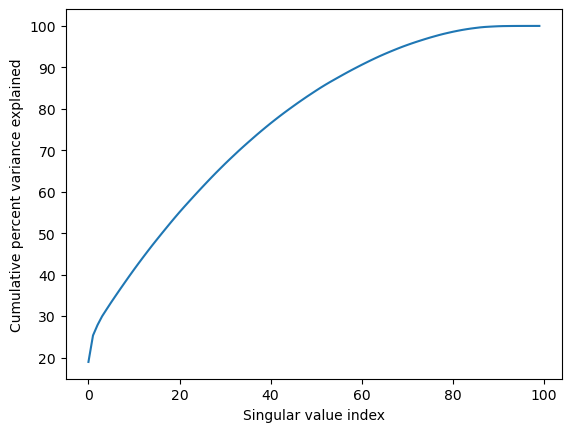

In [23]:
pve = final_svd_all.S**2
pve /= pve.sum()
pve = pve.cumsum(0) * 100
plt.plot(pve)
plt.ylabel("Cumulative percent variance explained")
# add xlabel
plt.xlabel("Singular value index")

In [24]:
final_svd_all.U

tensor([[ 0.0078, -0.0076,  0.0475,  ...,  0.0066,  0.0055, -0.0019],
        [-0.0031, -0.0140,  0.0442,  ..., -0.0003,  0.0038, -0.0004],
        [ 0.0021, -0.0021,  0.0189,  ...,  0.0029,  0.0026, -0.0115],
        ...,
        [-0.0085, -0.0152, -0.0037,  ..., -0.0115, -0.0026,  0.0023],
        [-0.0127, -0.0203, -0.0002,  ...,  0.0227, -0.0002, -0.0067],
        [-0.0092, -0.0125,  0.0016,  ..., -0.0120,  0.0002, -0.0066]])

In [25]:
final_svd_all.V.shape

torch.Size([100, 13598])

In [26]:
final_svd_all.S

tensor([158.7825,  92.1654,  58.0856,  52.7764,  47.5899,  47.2626,  46.4065,
         46.1629,  45.7435,  45.5746,  45.1160,  44.6543,  44.1939,  43.8360,
         43.4827,  42.8117,  42.6221,  42.3166,  42.2422,  41.7822,  41.3178,
         40.6702,  40.2031,  40.0967,  39.8876,  39.5829,  39.3671,  39.1474,
         38.7323,  38.2315,  38.0659,  37.4913,  37.1178,  37.0849,  36.4277,
         36.0785,  35.7985,  35.7185,  35.1481,  34.8435,  34.4791,  33.9893,
         33.6770,  33.2196,  32.8115,  32.4759,  32.3392,  31.7981,  31.6660,
         31.0696,  31.0136,  30.5815,  29.9621,  29.3460,  28.7434,  28.6775,
         28.5949,  28.3448,  27.9473,  27.5479,  27.4461,  26.9539,  26.8226,
         26.3401,  25.9344,  25.3545,  24.9090,  24.5348,  24.2830,  23.7857,
         23.0676,  22.6622,  22.1368,  21.6753,  21.4210,  21.0347,  20.3324,
         20.1386,  19.3439,  18.4093,  18.1259,  17.2310,  16.7197,  15.6480,
         14.7817,  13.7940,  13.4083,  11.5008,   9.5056,   8.77

In [27]:
E = final_svd_all.U * final_svd_all.S  #in U, these are like the PCs..., S are the scaling factors that quantify the amount of variance captured by each corresponding singular vector in U.
E

tensor([[ 1.2328e+00, -6.9608e-01,  2.7569e+00,  ...,  1.0300e-02,
          5.2704e-03, -1.5647e-03],
        [-4.9007e-01, -1.2939e+00,  2.5652e+00,  ..., -4.3460e-04,
          3.5889e-03, -2.9215e-04],
        [ 3.3199e-01, -1.9098e-01,  1.0958e+00,  ...,  4.5157e-03,
          2.4614e-03, -9.2476e-03],
        ...,
        [-1.3570e+00, -1.4015e+00, -2.1663e-01,  ..., -1.7797e-02,
         -2.5069e-03,  1.8425e-03],
        [-2.0128e+00, -1.8692e+00, -9.2636e-03,  ...,  3.5208e-02,
         -1.5690e-04, -5.3834e-03],
        [-1.4623e+00, -1.1519e+00,  9.5482e-02,  ..., -1.8618e-02,
          2.2302e-04, -5.3330e-03]])

In [28]:
color_palette = sns.color_palette("Set1", n_colors=len(cell_ids_conversion['cell_type'].unique()))
# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)

# Obtain cell type labels for every cell in the matrix also 
unique_cell_types = cell_ids_conversion['cell_type'].unique()
num_unique_types = len(unique_cell_types)
colors = sns.color_palette('Set1', n_colors=num_unique_types)  # You can use any color palette
cell_types = cell_ids_conversion.cell_type.values

# create colours for each cell type 
cell_type_colors = {cell_type: color for cell_type, color in zip(unique_cell_types, colors)}
row_colors = [cell_type_colors[cell_type] for cell_type in cell_types]

(array([1.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 3.00000e+00, 4.00000e+00, 1.00000e+00, 2.00000e+00,
        4.00000e+00, 4.00000e+00, 5.00000e+00, 4.00000e+00, 3.00000e+00,
        5.00000e+00, 5.00000e+00, 9.00000e+00, 7.00000e+00, 9.00000e+00,
        1.50000e+01, 5.00000e+00, 1.00000e+01, 7.00000e+00, 6.00000e+00,
        5.00000e+00, 5.00000e+00, 5.00000e+00, 6.00000e+00, 5.00000e+00,
        4.00000e+00, 7.00000e+00, 6.00000e+00, 1.00000e+01, 1.70000e+01,
        1.10000e+01, 1.60000e+01, 1.50000e+01, 3.30000e+01, 2.80000e+01,
        3.40000e+01, 3.60000e+01, 6.50000e+01, 6.00000e+01, 5.50000e+01,
        7.40000e+01, 7.50000e+01, 1.20000e+02, 1.21000e+02, 1.40000e+02,
        1.78000e+02, 2.86000e+02, 4.58000e+02, 7.10000e+02, 1.29400e+03,
        2.43000e+03, 4.91100e+03, 1.03180e+04, 2.13400e+04, 4.40590e+04,
        8.50670e+04, 1.76336e+05, 9.82890e+04, 5.13520e+04, 2.61620e+04,
        1.29810e+04, 6.69800e+03, 3.46600e+03, 1.96

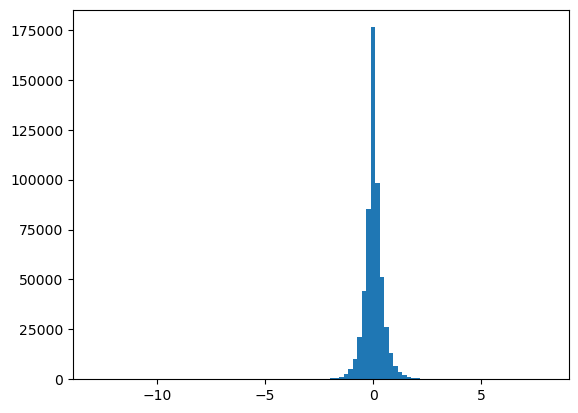

In [29]:
# make a histogram of all the values in the torch tensor E
plt.hist(E.flatten(), 100)

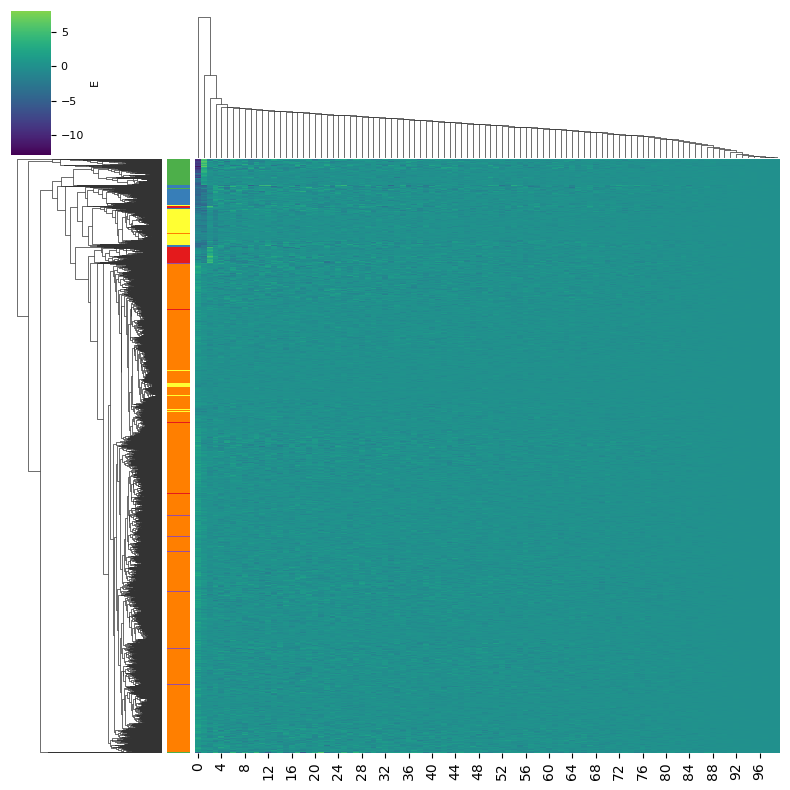

In [30]:
cluster = sns.clustermap(
    data=E,
    method='complete',
    cmap="viridis",
    annot=False,
    fmt=".2f",
    yticklabels=False,
    figsize=(8, 8),
    center=0,
    row_colors=row_colors,  # Apply row colors
    cbar_kws={'label': 'E'} 
    )
cluster.cax.set_ylabel('E', size=8)
# Increase font size for color bar tick labels:
cbar_ax = cluster.cax
for label in cbar_ax.yaxis.get_ticklabels():
    label.set_size(8)

Text(0.5, 0, 'Cell Type')

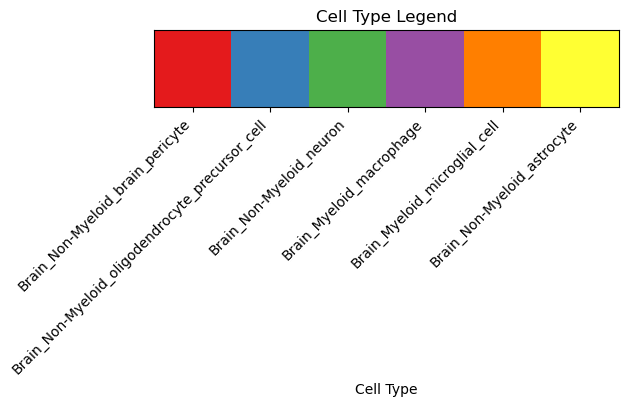

In [31]:
# print cell type color legend seperately
cell_type_colors
# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)
sns.palplot(color_palette)
plt.title("Cell Type Legend")
# add cell type names to legend
plt.xticks(np.arange(len(unique_cell_types)), unique_cell_types, rotation=45, ha='right')
plt.xlabel("Cell Type")

In [35]:
# let's calculate silhouette score ussing assign_post
silhouette_score(E, cell_types)

0.054035388